In [1]:
import dateutil
import matplotlib.pyplot as plt
import pandas
import re
import requests
import seaborn

from collections import Counter
from datetime import datetime
from user_agent import generate_user_agent
from bs4 import BeautifulSoup

In [2]:
keyword = 'Django'
area = 2  # 1 - MSK, 2 - SPB
salary = 120 * 1000  # RUR

In [3]:
BASE_URL = 'https://api.hh.ru'

In [4]:
params = dict(
    order_by='salary_desc',
    text=keyword,
    area=area,
    period=30, # days
    per_page=100,
    no_magic='false',  # disable magic
    vacancy_search_fields='description',  # available: name, description, company_name
)
response = requests.get(
    BASE_URL + '/vacancies',
    headers={'User-Agent': generate_user_agent()},
    params=params,
)
response

<Response [200]>

## Main info

In [5]:
items = response.json()['items']
vacancies = []
for item in items:
    vacancies.append(dict(
        id=item['id'],
        name=item['name'],
        salary_from=item['salary']['from'] if item['salary'] else None,
        salary_to=item['salary']['to'] if item['salary'] else None,
        created=item['published_at'],
        company=item['employer']['name'],
        company_id=item['employer']['id'],
    ))

vacancies = pandas.DataFrame(
    vacancies,
    columns=['id', 'name', 'salary_from', 'salary_to', 'created', 'company_id', 'company'],
)

In [6]:
vacancies.head()

,id,name,salary_from,salary_to,created,company_id,company
0,25608352,"Senior Full Stack Developer (React.js, Backbon...",3800.0,5400.0,2018-04-27T19:22:25+0300,141547,КА Натальи Зотовой
1,21072095,Senior Backend Developer (Кипр),3000.0,NaN,2018-04-23T12:31:42+0300,1818108,IBIT
2,24827105,Back-End Web Developer (Python),200000.0,300000.0,2018-04-28T15:53:20+0300,1738507,Soshace
3,22056926,Senior Software Developer (PyCharm),180000.0,NaN,2018-04-09T18:34:04+0300,9281,JetBrains
4,25195178,Python разработчик,170000.0,220000.0,2018-04-27T19:07:42+0300,2068941,Cindicator


In [7]:
# convert ISO string to datetime
vacancies['created'] = vacancies['created'].apply(lambda x: dateutil.parser.parse(x))

In [8]:
# extract weekday and publish time from vacancies
vacancies['weekday'] = vacancies['created'].apply(lambda x: x.weekday() + 1)
vacancies['hour'] = vacancies['created'].apply(lambda x: x.hour)

In [9]:
vacancies.head()

,id,name,salary_from,salary_to,created,company_id,company,weekday,hour
0,25608352,"Senior Full Stack Developer (React.js, Backbon...",3800.0,5400.0,2018-04-27 19:22:25+03:00,141547,КА Натальи Зотовой,5,19
1,21072095,Senior Backend Developer (Кипр),3000.0,NaN,2018-04-23 12:31:42+03:00,1818108,IBIT,1,12
2,24827105,Back-End Web Developer (Python),200000.0,300000.0,2018-04-28 15:53:20+03:00,1738507,Soshace,6,15
3,22056926,Senior Software Developer (PyCharm),180000.0,NaN,2018-04-09 18:34:04+03:00,9281,JetBrains,1,18
4,25195178,Python разработчик,170000.0,220000.0,2018-04-27 19:07:42+03:00,2068941,Cindicator,5,19


In [10]:
vacancies.describe()

,salary_from,salary_to,weekday,hour
count,26.000000,15.000000,59.000000,59.000000
mean,87884.615385,117560.000000,3.796610,13.847458
std,58800.521714,80869.319628,1.927833,3.872153
min,1200.000000,3000.000000,1.000000,5.000000
25%,38750.000000,62500.000000,2.000000,11.000000
50%,85000.000000,100000.000000,4.000000,13.000000
75%,127500.000000,150000.000000,5.000000,17.000000
max,200000.000000,300000.000000,7.000000,22.000000


In [11]:
%matplotlib inline

Let's find hardest HR's days and hours

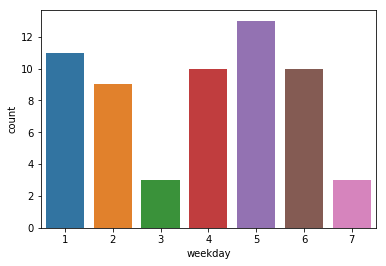

In [12]:
seaborn.countplot(vacancies.weekday)

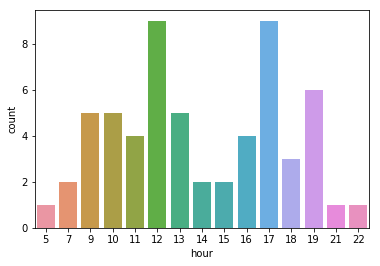

In [13]:
seaborn.countplot(vacancies.hour)

Companies that work in night or holydays:

In [14]:
blacklist = vacancies[(vacancies.hour >= 20) | (vacancies.hour < 10) | (vacancies.weekday > 5)]
blacklist.sort_values('company')[['company', 'weekday', 'hour']]

,company,weekday,hour
14,"ACQUIRED IO, INC",6,18
5,Investex Ltd,4,9
30,Itransition,6,10
10,JetBrains,6,17
13,Mediterra,7,15
38,NETRIKA,3,9
55,OpenWay Group,1,7
36,SMART HR,4,9
31,Softline,4,5
2,Soshace,6,15


Let's analize salaries!

In [15]:
sfrom = vacancies[vacancies.salary_from > 10000].salary_from.min()
sto = vacancies.salary_to.mean()
sfrom, sto

(20000.0, 117560.0)

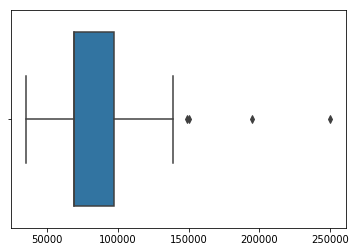

In [16]:
def avg_salary(row):
    if pandas.isnull(row.salary_from) or row.salary_from < 10000:
        f = sfrom
    else:
        f = row.salary_from
    if pandas.isnull(row.salary_to) or row.salary_to < 10000:
        t = sto
    else:
        t = row.salary_to
    return float(f + t) / 2

seaborn.boxplot(vacancies.apply(avg_salary, axis=1))

## Keywords

In [17]:
rex = re.compile(r'[A-Za-z ]{3,}')

In [18]:
keywords = []
for vid in vacancies['id']:
    response = requests.get(
        BASE_URL + '/vacancies/{vacancy_id}'.format(vacancy_id=vid),
        headers={'User-Agent': generate_user_agent()},
    )
    text = response.json()['description']
    text = BeautifulSoup(text, 'html.parser').get_text()
    keywords.extend(rex.findall(text))

In [19]:
keywords = [kw.lower().strip() for kw in keywords]
keywords = [kw for kw in keywords if kw]

In [20]:
keywords_dataframe = pandas.DataFrame(Counter(keywords).most_common(40), columns=['keyword', 'count'])

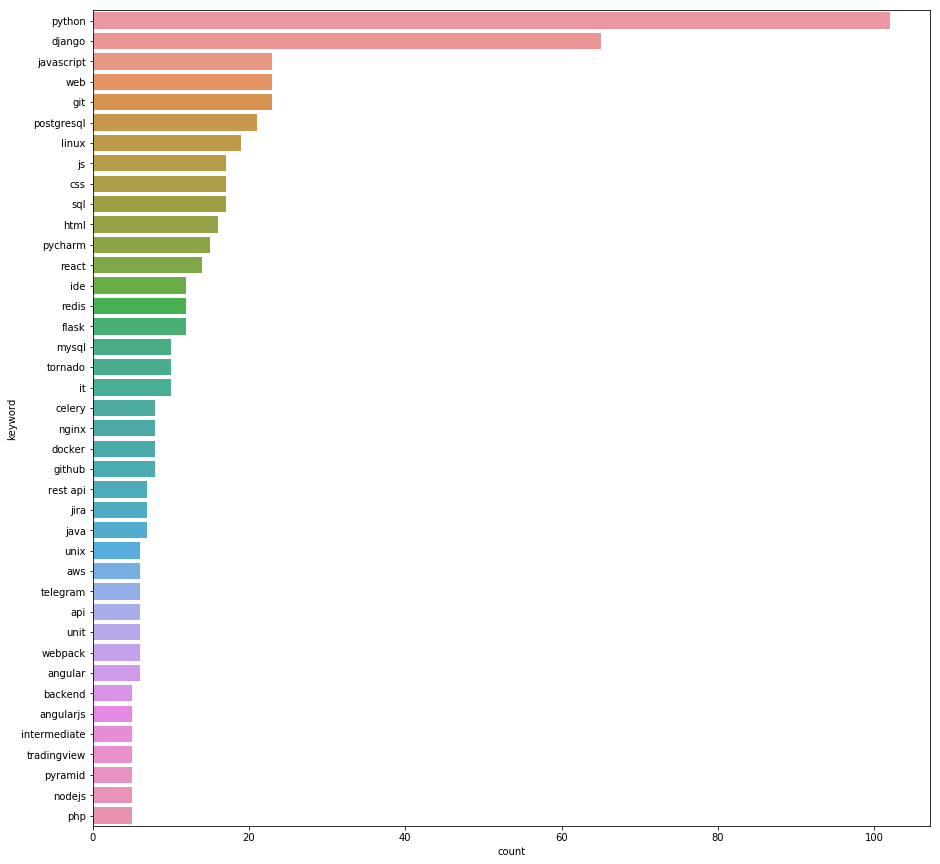

In [21]:
a4_dims = (15, 15)
fig, ax = plt.subplots(figsize=a4_dims)

seaborn.barplot(data=keywords_dataframe, x='count', y='keyword', ax=ax)

## Company info

In [22]:
areas = []
cids = set()
for cid, cname in zip(vacancies.company_id, vacancies.company):
    # only unique requests
    if cid in cids:
        continue
    cids.add(cid)

    # retrieve
    params = dict(
        employer_id=cid,
        area=area,
        period=30,
        per_page=0,
        clusters='true',
    )
    response = requests.get(
        BASE_URL + '/vacancies',
        headers={'User-Agent': generate_user_agent()},
        params=params,
    )

    # analize clusters
    for cluster in response.json()['clusters']:
        if cluster['id'] == 'professional_area':
            good = total = 0
            for item in cluster['items']:
                if item['name'] == 'Информационные технологии, интернет, телеком':
                    good += item['count']
                total += item['count']
            areas.append(dict(
                company=cname,
                company_id=cid,
                count=total,
                rate=good / total
            ))

In [23]:
areas_dataframe = pandas.DataFrame(areas, columns=['company', 'company_id', 'count', 'rate'])

Mostly tech companies:

In [24]:
areas_dataframe = areas_dataframe.sort_values(by='rate', ascending=False)
areas_dataframe = areas_dataframe.reset_index()
areas_dataframe = areas_dataframe.drop('index', 1)
areas_dataframe[areas_dataframe.rate >= .5]

,company,company_id,count,rate
0,Luxoft,1304,40,0.925000
1,БиАйЭй-Технолоджиз,2565797,37,0.864865
2,First Line Software,638130,20,0.850000
3,JetBrains,9281,81,0.814815
4,OpenWay Group,4156,15,0.800000
5,"EPAM Systems, Inc.",6769,44,0.750000
6,Wargaming,662769,38,0.657895
7,SEMrush,789662,61,0.639344
8,i-FREE,18062,35,0.571429
9,Softline,2381,28,0.571429


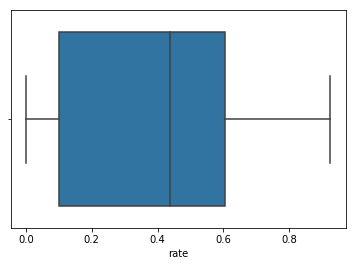

In [25]:
seaborn.boxplot(areas_dataframe.rate)

# One company info

In [26]:
cid = areas_dataframe.company_id[0]

In [27]:
areas_dataframe[areas_dataframe.company_id == cid]

,company,company_id,count,rate
0,Luxoft,1304,40,0.925


In [28]:
# retrieve
params = dict(
    employer_id=cid,
    area=area,
    period=30, # days
    per_page=100,
)
response = requests.get(
    BASE_URL + '/vacancies',
    headers={'User-Agent': generate_user_agent()},
    params=params,
)
response

<Response [200]>

In [29]:
company_vacancies = []
for item in response.json()['items']:
    company_vacancies.append(dict(
        id=item['id'],
        name=item['name'],
        salary_from=item['salary']['from'] if item['salary'] else None,
        salary_to=item['salary']['to'] if item['salary'] else None,
        created=dateutil.parser.parse(item['published_at']),
    ))

company_vacancies = pandas.DataFrame(
    company_vacancies,
    columns=['id', 'name', 'salary_from', 'salary_to', 'created'],
)

In [30]:
company_vacancies.head(10)

,id,name,salary_from,salary_to,created
0,25614924,C/C++ developer,None,None,2018-04-28 12:07:02+03:00
1,25614538,Lead/senior angular developer,None,None,2018-04-28 11:52:33+03:00
2,25614274,C / C++ developer,None,None,2018-04-28 11:45:41+03:00
3,25614246,Senior Project Manager,None,None,2018-04-28 11:44:04+03:00
4,25614199,Senior 3D plugin developer,None,None,2018-04-28 11:42:30+03:00
5,25614181,GPU GCN developer,None,None,2018-04-28 11:41:57+03:00
6,25614170,Senior java developer,None,None,2018-04-28 11:41:25+03:00
7,25614126,Test Automation developer,None,None,2018-04-28 11:39:39+03:00
8,25614120,Senior JS / Angular4 developer,None,None,2018-04-28 11:39:16+03:00
9,25614116,Fullstack Senior ASP.NET Core + Angular developer,None,None,2018-04-28 11:39:04+03:00


In [31]:
company_vacancies.count()

id             39
name           39
salary_from     0
salary_to       0
created        39
dtype: int64

In [32]:
company_vacancies['weekday'] = company_vacancies['created'].apply(lambda x: x.weekday() + 1)
company_vacancies['hour'] = company_vacancies['created'].apply(lambda x: x.hour)

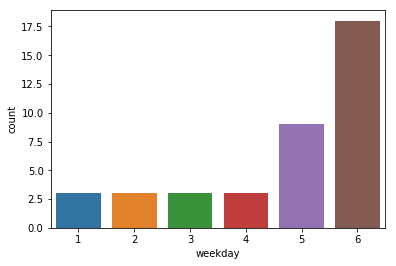

In [33]:
seaborn.countplot(company_vacancies.weekday)

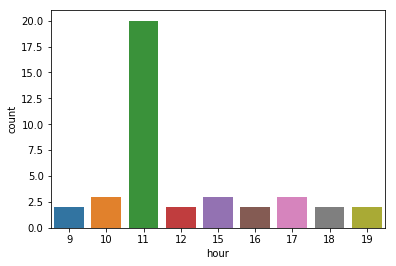

In [34]:
seaborn.countplot(company_vacancies.hour)

In [35]:
sfrom = company_vacancies[company_vacancies.salary_from > 10000].salary_from.min()
sto = company_vacancies.salary_to.min()

sfrom, sto

(nan, nan)

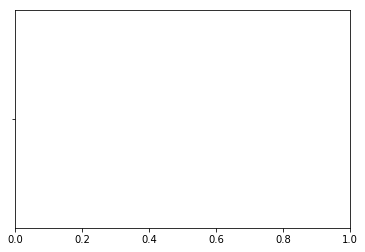

In [36]:
def avg_salary(row):
    if pandas.isnull(row.salary_from) or row.salary_from < 10000:
        f = sfrom
    else:
        f = row.salary_from
    if pandas.isnull(row.salary_to) or row.salary_to < 10000:
        t = sto
    else:
        t = row.salary_to
    return float(f + t) / 2

seaborn.boxplot(company_vacancies.apply(avg_salary, axis=1))